<a href="https://colab.research.google.com/github/giogarulli/NeuralMagnetControl/blob/main/MagnetControlTestNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLPNS 2023 May exam
Giovanni Garulli, PhD Student in Materials' Science and Technology

**Reproducibility**

For reproducibility, this notebook expects your kaggle.json API credentials file to be placed in a directory named .kaggle and placed inside the directory MyDrive of your Google Drive.
The code will create a new directory named MLPNS23_final inside MyDrive.
The code is designed to skip the extraction of files and creation of folders if those are already present.






# TASK I :  Data Acquisition

  First thing to do, mount the Google Drive, install the required packages and import the needed modules

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# all imports here
import pandas as pd
from pandas.core.reshape.encoding import get_dummies
from pandas.core.api import value_counts
from pandas.core.groupby import groupby
from pandas.core.groupby.groupby import sample
import numpy as np
import pylab as pl
import os
import json
import corner
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import gc

In [ ]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


Mkdir with -p option skips if the directory already exists

In [ ]:
!mkdir -p MLPNS23_final

In [ ]:
cd /content/gdrive/MyDrive/MLPNS23_final

/content/gdrive/MyDrive/MLPNS23_final


In [ ]:
envs = json.load(open("/content/gdrive/MyDrive/.kaggle/kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [ ]:
!kaggle competitions download -c champs-scalar-coupling

champs-scalar-coupling.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
ls

 champs-scalar-coupling.zip            potential_energy.csv
'Copia 2 di MLPNS23_final_May.ipynb'   sample_submission.csv
'Copia di MLPNS23_final_May.ipynb'     scalar_coupling_contributions.csv
 dipole_moments.csv                    scalar_coupling_nn_std/
 magnetic_shielding_tensors.csv        structures.csv
 MLPNS23_final_May.ipynb               test.csv
 mulliken_charges.csv                  train.csv


The -n option skips already extracted files, the -x option was used to skip the structures subdirectory

In [ ]:
!unzip -n champs-scalar-coupling.zip -x structures/*

Archive:  champs-scalar-coupling.zip


Let's load the train dataset and take a look at it

In [ ]:
train = pd.read_csv("train.csv",index_col="id")
train

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,dsgdb9nsd_000001,1,0,1JHC,84.807600
1,dsgdb9nsd_000001,1,2,2JHH,-11.257000
2,dsgdb9nsd_000001,1,3,2JHH,-11.254800
3,dsgdb9nsd_000001,1,4,2JHH,-11.254300
4,dsgdb9nsd_000001,2,0,1JHC,84.807400
...,...,...,...,...,...
4659071,dsgdb9nsd_133884,17,4,2JHC,3.543450
4659072,dsgdb9nsd_133884,17,5,3JHC,0.568997
4659073,dsgdb9nsd_133884,17,6,3JHC,1.173370


The structure dataset needs to be loaded and inspected too

In [ ]:
structure = pd.read_csv("structures.csv")
structure

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
...,...,...,...,...,...,...
2358870,dsgdb9nsd_133885,11,H,-1.454004,-0.967309,1.459246
2358871,dsgdb9nsd_133885,12,H,0.277779,-2.697872,0.195770
2358872,dsgdb9nsd_133885,13,H,2.515854,-1.151784,0.527369
2358873,dsgdb9nsd_133885,14,H,0.013699,1.199431,-1.680192


# TASK II :  Data Cleaning, Preparation, and Fusion

The target variable is `scalar_coupling_constant`

**Answer this Question (in a text cell)**: which kind of machine learning task are we performing if we want to predict `scalar_coupling_constant` (given the nature of this variable):

**`scalar_coupling_constant` is populated by continuous values, this means we are performing a regression task!**

In [ ]:
train.shape

(4659076, 5)

In [ ]:
train.describe()

,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.659076e+06,4.659076e+06,4.659076e+06
mean,1.335677e+01,5.881245e+00,1.591591e+01
std,3.269432e+00,4.993794e+00,3.493466e+01
min,1.000000e+00,0.000000e+00,-4.476050e+01
25%,1.100000e+01,2.000000e+00,-2.551462e-01
50%,1.300000e+01,5.000000e+00,2.280350e+00
75%,1.600000e+01,8.000000e+00,7.389100e+00
max,2.800000e+01,2.800000e+01,2.077090e+02


From here the dataset doesn't seem to present rows with missing values. Let's check it explicitly:

In [ ]:
train.isna().sum()

molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
dtype: int64

The database doesn't seem to contain not-a-number values!
Now it's necessary to check if we have rows where the scalar coupling constant has a value of exactly zero, which may be of non-phyisical meaning

In [ ]:
print(f'The original train dataset contains {np.sum(train["scalar_coupling_constant"]==0)} rows where scalar_coupling_constant is exactly 0 (may be a not-a-number kind of encoding)');

The original train dataset contains 0 rows where scalar_coupling_constant is exactly 0 (may be a not-a-number kind of encoding)


It's imperative to check if in the dataset some records are duplicates

In [ ]:
print(f'The original train dataset contains {train.duplicated(subset=["molecule_name","atom_index_0","atom_index_1"]).sum()} duplicated rows');

The original train dataset contains 0 duplicated rows


Maybe there are rows that are unique with respect to molecule_name, atom_index_0 and atom_index_1 but that have only atom indexes swapped! Better check for that

In [ ]:
count_duplicated = pd.DataFrame({'molecule_name': train["molecule_name"].values,
              'atom_index_0': np.min(train[["atom_index_0","atom_index_1"]].values, axis=1),
              'atom_index_1': np.max(train[["atom_index_0","atom_index_1"]].values, axis=1)}).duplicated().sum()
print(f'The original train dataset contains {count_duplicated} duplicated rows, taking into account atom index swaps');

The original train dataset contains 0 duplicated rows, taking into account atom index swaps


The structure dataset was also checked for duplicate rows

In [ ]:
print(f"The structure dataset contains {structure.duplicated(subset=['molecule_name','atom_index']).sum()} duplicates, taiking into account molecule name and atom index")

The structure dataset contains 0 duplicates, taiking into account molecule name and atom index


In [ ]:
print(f"The original train dataset contains {len(train.columns)-1} features for {len(train['molecule_name'].unique())} molecules")

The original train dataset contains 4 features for 85012 molecules


None of the records were removed from the dataset, because there were no duplicates of the same atom-indexes couple for the same molecule. This way, atoms of the same type but in different positions inside the same molecule (identified by molecule_name) are not discarded!

The original dataset now needs to be merged with the structure data. Molecule names and atom indexes (for atom 0 first, then for atom 1) were used as keys for the merging process. Redundant or not-needed columns obtained during the merge were then dropped

In [ ]:
merged_train = train.merge(structure, left_on=["molecule_name","atom_index_0"], right_on=["molecule_name","atom_index"]);
merged_train = merged_train.merge(structure, left_on=["molecule_name","atom_index_1"], right_on=["molecule_name","atom_index"],suffixes=('_a','_b'));
merged_train.drop(columns=['atom_index_a','atom_a','atom_index_b','atom_b'],inplace=True);
merged_train

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,x_a,y_a,z_a,x_b,y_b,z_b
0,dsgdb9nsd_000001,1,0,1JHC,84.807600,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,2,0,1JHC,84.807400,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001
2,dsgdb9nsd_000001,3,0,1JHC,84.809300,-0.540815,1.447527,-0.876644,-0.012698,1.085804,0.008001
3,dsgdb9nsd_000001,4,0,1JHC,84.809500,-0.523814,1.437933,0.906397,-0.012698,1.085804,0.008001
4,dsgdb9nsd_000001,1,2,2JHH,-11.257000,0.002150,-0.006031,0.001976,1.011731,1.463751,0.000277
...,...,...,...,...,...,...,...,...,...,...,...
4659071,dsgdb9nsd_133884,13,17,3JHH,3.062820,2.582409,-1.260138,0.293499,1.126550,-1.348733,-1.933838
4659072,dsgdb9nsd_133884,16,17,3JHH,0.789559,-0.084531,1.110807,-1.796741,1.126550,-1.348733,-1.933838
4659073,dsgdb9nsd_133884,13,14,3JHH,1.005250,2.582409,-1.260138,0.293499,2.087537,1.391489,0.548687
4659074,dsgdb9nsd_133884,13,15,3JHH,1.005260,2.582409,-1.260138,0.293499,1.542918,0.547487,2.023550


In [ ]:
print(f"After the merge the dataset contains {len(merged_train.columns)-1} features for {len(merged_train['molecule_name'].unique())} molecules")

After the merge the dataset contains 10 features for 85012 molecules


Here the one-hot-encoding method was used for the encoding coupling type. This is preferrable to numeral encoding because coupling types do not have an intrinsic meaningful ordering that can be used in the model.

In [ ]:
merged_train = merged_train.merge(pd.get_dummies(merged_train[u'type']), left_index=True, right_index=True).drop(columns="type")
merged_train

,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,x_a,y_a,z_a,x_b,y_b,z_b,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
0,dsgdb9nsd_000001,1,0,84.807600,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001,1,0,0,0,0,0,0,0
1,dsgdb9nsd_000001,2,0,84.807400,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001,1,0,0,0,0,0,0,0
2,dsgdb9nsd_000001,3,0,84.809300,-0.540815,1.447527,-0.876644,-0.012698,1.085804,0.008001,1,0,0,0,0,0,0,0
3,dsgdb9nsd_000001,4,0,84.809500,-0.523814,1.437933,0.906397,-0.012698,1.085804,0.008001,1,0,0,0,0,0,0,0
4,dsgdb9nsd_000001,1,2,-11.257000,0.002150,-0.006031,0.001976,1.011731,1.463751,0.000277,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659071,dsgdb9nsd_133884,13,17,3.062820,2.582409,-1.260138,0.293499,1.126550,-1.348733,-1.933838,0,0,0,0,0,0,1,0
4659072,dsgdb9nsd_133884,16,17,0.789559,-0.084531,1.110807,-1.796741,1.126550,-1.348733,-1.933838,0,0,0,0,0,0,1,0
4659073,dsgdb9nsd_133884,13,14,1.005250,2.582409,-1.260138,0.293499,2.087537,1.391489,0.548687,0,0,0,0,0,0,1,0
4659074,dsgdb9nsd_133884,13,15,1.005260,2.582409,-1.260138,0.293499,1.542918,0.547487,2.023550,0,0,0,0,0,0,1,0


In [ ]:
print(f"After one-hot-encoding the dataset contains {len(merged_train.columns)-1} features for {len(merged_train['molecule_name'].unique())} molecules")

After one-hot-encoding the dataset contains 17 features for 85012 molecules


In [ ]:
merged_train.shape

(4659076, 18)

# TASK III :  Data Explorations

In [ ]:
coupling_types = train["type"].unique()
coupling_types

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [ ]:
print(f"The dataset contains {len(coupling_types)} types of coupling")

The dataset contains 8 types of coupling


Text(0, 0.5, 'Occurrences counts')

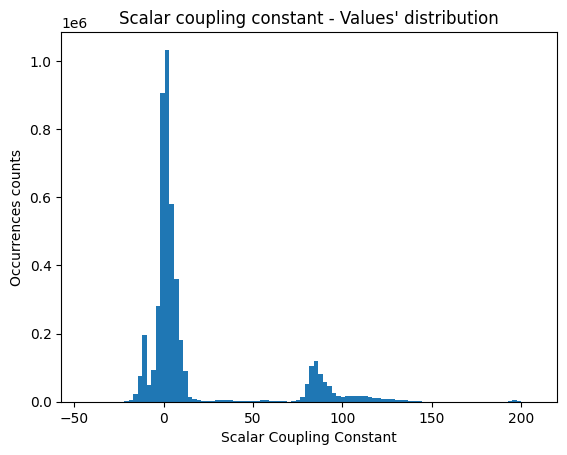

In [ ]:
pl.hist(train["scalar_coupling_constant"],bins=100);
pl.title("Scalar coupling constant - Values' distribution")
pl.xlabel("Scalar Coupling Constant")
pl.ylabel("Occurrences counts")

The scalar coupling constant values have a non-symmetric, multi-modal distribution. This can be a problem because the model could learn more about the regions where there are more data points and less from where fewer data points are present.

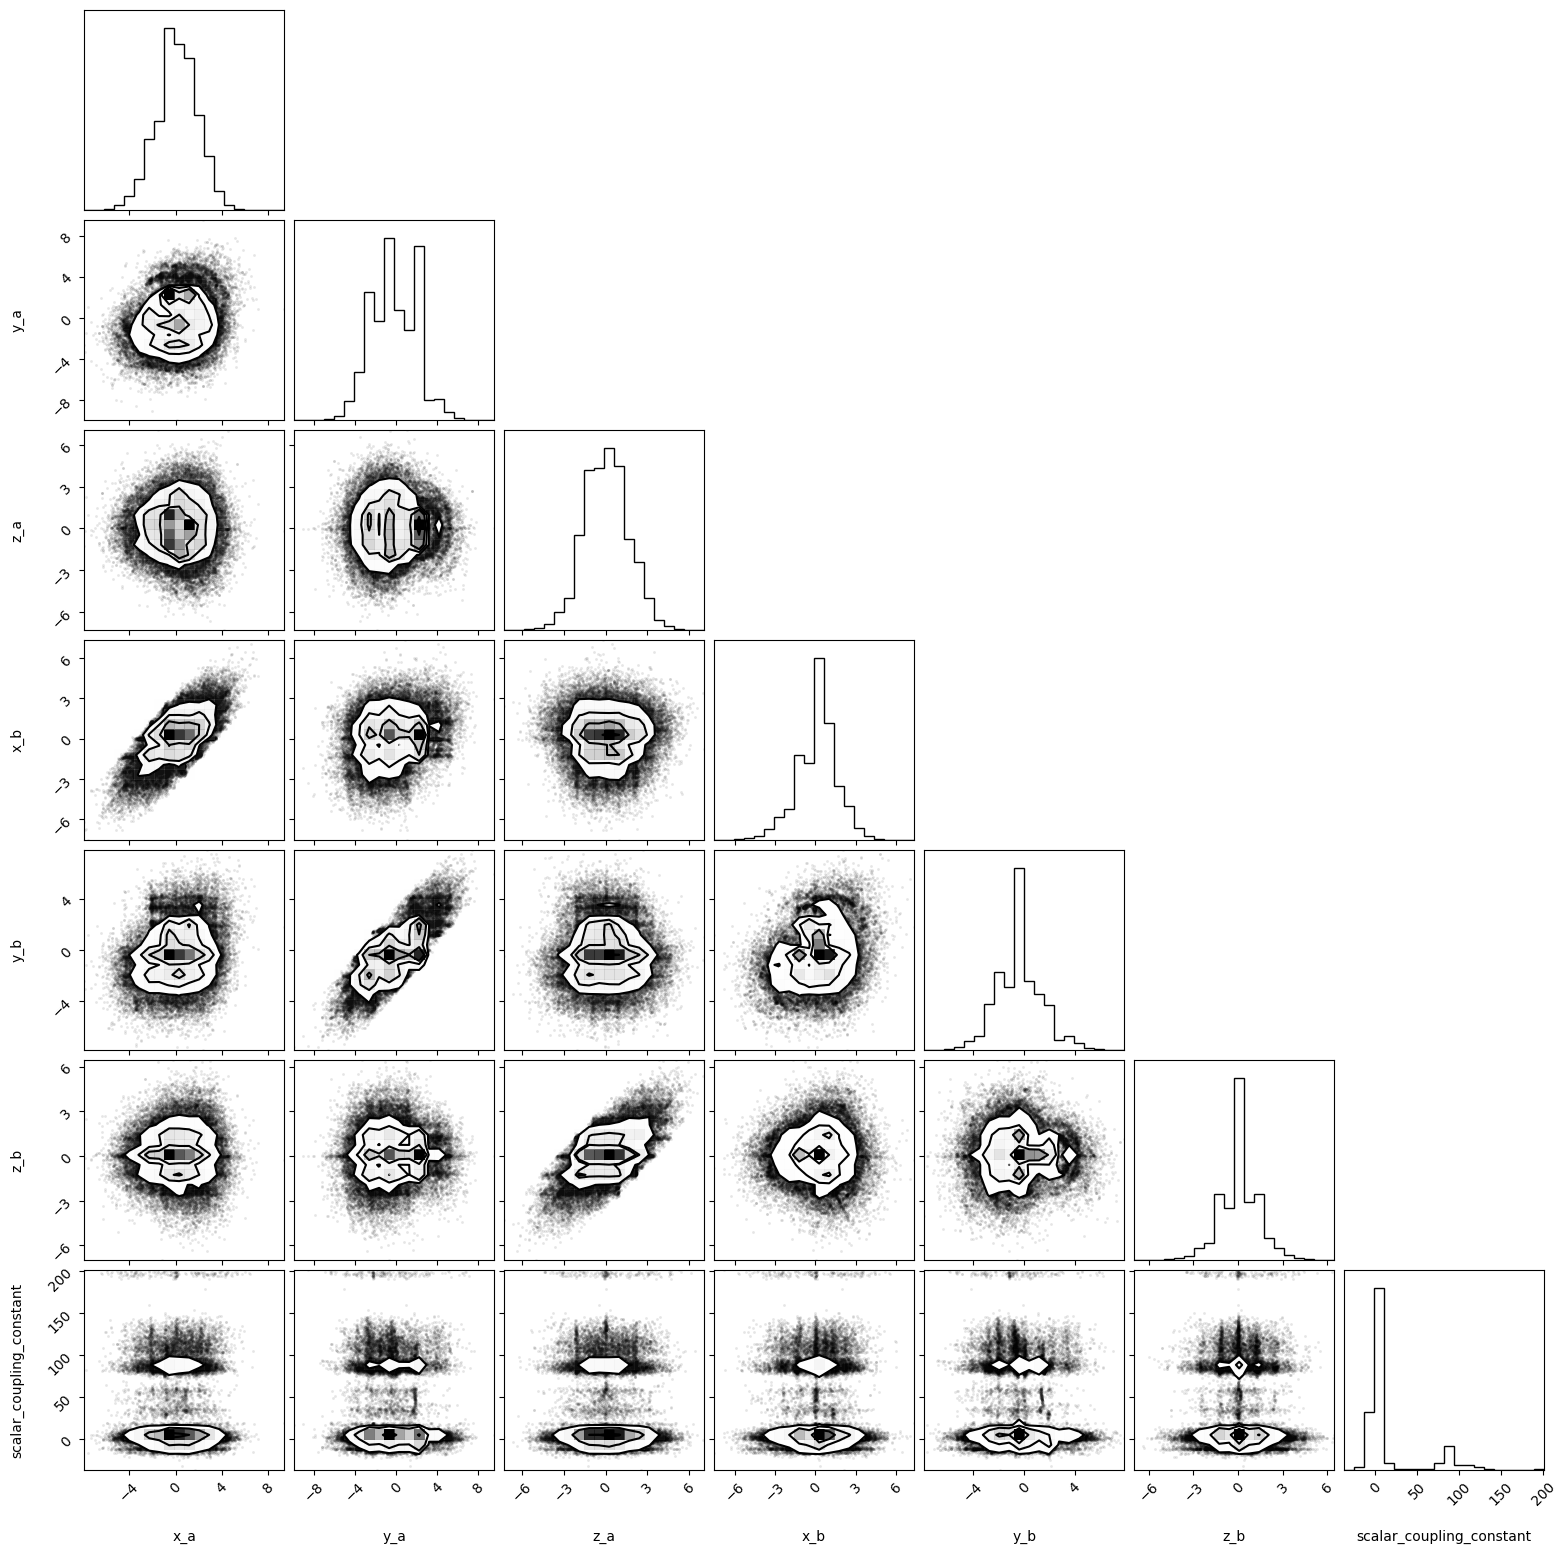

In [ ]:
fig = corner.corner(merged_train[["x_a","y_a","z_a","x_b","y_b","z_b","scalar_coupling_constant"]].sample(n=100000,random_state=48).values,
              labels=["x_a","y_a","z_a","x_b","y_b","z_b","scalar_coupling_constant"])
del fig

Here it's useful to perform a garbage collection to deal with the large amount of RAM used by corner.corner

In [ ]:
gc.collect()

134480

We see that the scalar coupling constant doesn't have a clear covariance with individual spatial coordinates.
We observe instead covariance between corresponding coordinates of atom 0 and atom 1 of each sample, suggesting that atoms reported in the data set may be close one to each other inside the molecule, which seems reasonable from the physics of this phenomenon

Text(0.5, 1.0, 'Coupling type abundance')

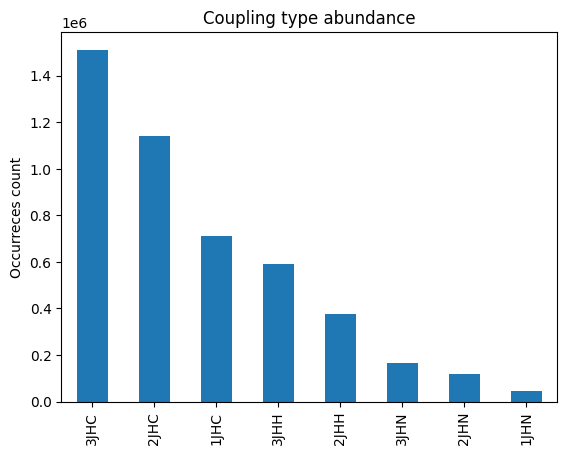

In [ ]:
train["type"].value_counts().plot(kind='bar')
pl.ylabel("Occurreces count")
pl.title("Coupling type abundance")

Different types of coupling are not present in the same quantity, this could influence too the ability of the model to learn from certain types of features.
Here there's no simple way of balancing the dataset and flatten the coupling type/scalar coupling constant distributions, so the dataset is kept as-is.
Special care will be used when splitting the data set in train/test sets to mantain the train and test sets balanced.

Text(0.5, 0, 'Atom count')

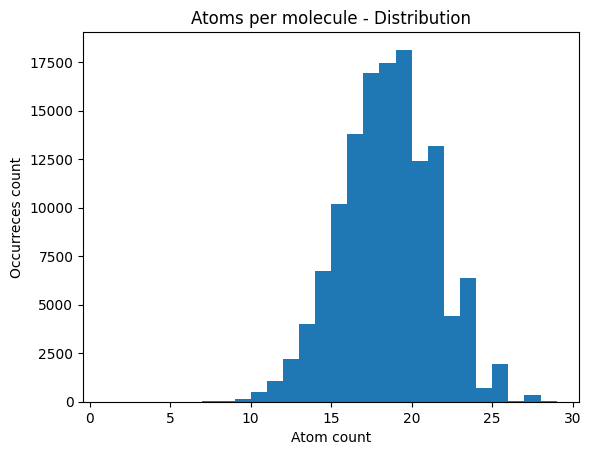

In [ ]:
atom_count_df = structure[["molecule_name","atom_index"]].groupby("molecule_name").count()
pl.hist(atom_count_df.values,bins=range(1,30))
pl.title("Atoms per molecule - Distribution")
pl.ylabel("Occurreces count")
pl.xlabel("Atom count")

The total number of atoms per molecule was calculated from the structures dataset and the distribution of this parameter observed. The distribution is bell-shaped and symmetric, so it could be assumed that the dataset contains molecules of dimensions that follow a gaussian-like distribution

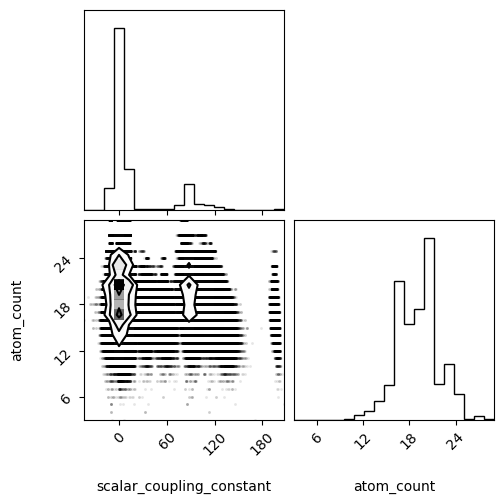

In [ ]:
atom_count_df.rename(columns={"atom_index":"atom_count"},inplace=True)
merged_all = merged_train.merge(atom_count_df, left_on=["molecule_name"], right_on=["molecule_name"])
fig = corner.corner(merged_all[["scalar_coupling_constant","atom_count"]].values,labels=["scalar_coupling_constant","atom_count"])
del fig
del merged_all
del atom_count_df

There's no evident correlation between the scalar coupling constant and the number of atoms in the molecule's structure

In [ ]:
gc.collect()

11071

Text(0.5, 0.98, 'Scalar coupling constant - Distribution histogram for different coupling types')

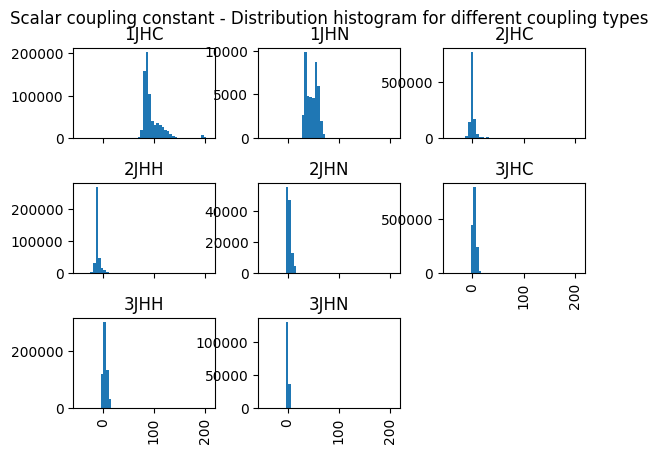

In [ ]:
train.hist(by='type',column='scalar_coupling_constant',
           bins=np.linspace(min(train.scalar_coupling_constant.values),max(train.scalar_coupling_constant.values),num=50),
           sharex=True);
pl.suptitle("Scalar coupling constant - Distribution histogram for different coupling types")

Here the distribution of the scalar coupling constant values was investigated for different types of coupling.
Different coupling types have different distributions of the values of the scalar coupling constant, but without a simple or evident correlation. A model based on the coupling type alone is very unlikely to lead to an accurate prediction of the coupling constant

# Task IV: model choice and preprocessing

The task seems complex, without evident correlation or simple shortcuts, so the neural network approach was chosen.
The data set is made of a large number of data points, this makes reasonable the training of a neural network even with a large number of parameters.

The dataset was split in train and test set. Each set should contain an equal number of molecules. Once a molecule is picked to be inserted in one of the sets, all the info about the molecule should go in the set (i.e. every couple of atoms belonging to that molecule with a value of the coupling constant)
Molecule names should be shuffled before distribution to ensure an even distribution of feature values in the train and test sets (this will be checked afterwards)

Here unique molecule names are shuffled randomly and then split in two identical sets

In [ ]:
# Use the following two rows to select a subset of the data during development, leave commented otherwise
#sample_size = 200;
#molecules = merged_train.molecule_name.drop_duplicates().sample(n=2*sample_size,random_state=23)

molecules = merged_train.molecule_name.drop_duplicates().sample(frac=1,random_state=23) # Shuffle molecule names
molecules_train = molecules.sample(frac=0.5,random_state=23)
molecules_test = molecules.drop(molecules_train.index)

All the features about the selected molecules were retrieved from the original dataset to build the final train and test sets.
Scalar coupling constant values and coupling type ditributions were observed to ensure an even distribution of those features between train and test set.

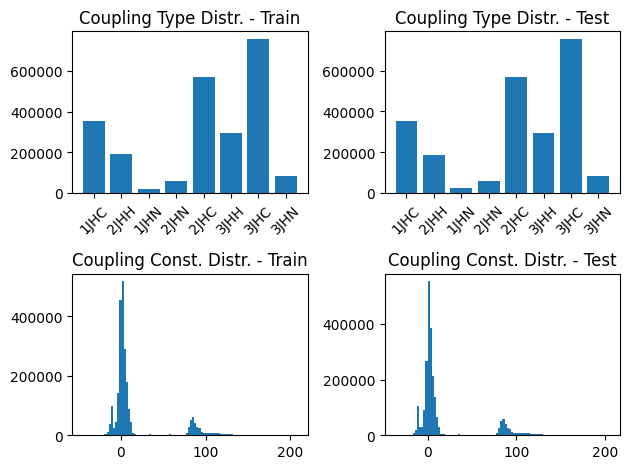

In [ ]:
X_train_DF = pd.DataFrame(molecules_train).merge(merged_train,left_on="molecule_name", right_on="molecule_name")
X_test_DF = pd.DataFrame(molecules_test).merge(merged_train,left_on="molecule_name", right_on="molecule_name")

fig, axes = pl.subplots(nrows=2, ncols=2)
axes[0,0].bar(coupling_types,np.sum(X_train_DF[coupling_types],axis=0))
axes[0,1].bar(coupling_types,np.sum(X_test_DF[coupling_types],axis=0))

y_train = X_train_DF["scalar_coupling_constant"].values
y_test = X_test_DF["scalar_coupling_constant"].values

axes[1,0].hist(y_train,bins=100)
axes[1,1].hist(y_test,bins=100)

X_train = X_train_DF.drop(columns=["molecule_name","atom_index_0","atom_index_1","scalar_coupling_constant"]).values
X_test = X_test_DF.drop(columns=["molecule_name","atom_index_0","atom_index_1","scalar_coupling_constant"]).values

axes[0,0].tick_params(axis='x', labelrotation = 45)
axes[0,1].tick_params(axis='x', labelrotation = 45)
axes[0,0].set_title("Coupling Type Distr. - Train")
axes[0,1].set_title("Coupling Type Distr. - Test")
axes[1,0].set_title("Coupling Const. Distr. - Train")
axes[1,1].set_title("Coupling Const. Distr. - Test")
fig.tight_layout();

The coupling constant values and the coupling types seem to follow the same distribution in the train and test set!

In [ ]:
X_test.shape

(2325341, 14)

In [ ]:
X_train.shape

(2333735, 14)

The nature of the problem seems complex, so a neural network topology of 4 dense layers with activation function "tanh" was chosen. The layer size used is 16x16x8x1. The activation function for the output neuron was set as linear. The loss function was set to mean-average-error and "adam" was used as optimizer.

In [ ]:
ilayer = keras.layers.Dense(16, input_dim=14, activation="tanh")
hlayer1 = keras.layers.Dense(16, activation="tanh")
hlayer2 = keras.layers.Dense(8, activation="tanh")
olayer = keras.layers.Dense(1, activation="linear")
model = keras.Sequential([ilayer, hlayer1, hlayer2, olayer])
model.compile(loss = "mae", optimizer="adam", metrics="mae")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


The training was performed on the whole training set, with batches of 512 records and for 50 epochs.

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(X_test,y_test))
# model.save("scalar_coupling_nn_std"); # uncomment to save the trained model to disk

Epoch 1/50
4559/4559 [==============================] - 33s 6ms/step - loss: 12.9924 - mae: 12.9924 - val_loss: 9.7133 - val_mae: 9.7133
Epoch 2/50
4559/4559 [==============================] - 28s 6ms/step - loss: 6.7283 - mae: 6.7283 - val_loss: 3.9909 - val_mae: 3.9909
Epoch 3/50
4559/4559 [==============================] - 26s 6ms/step - loss: 3.7914 - mae: 3.7914 - val_loss: 3.7672 - val_mae: 3.7672
Epoch 4/50
4559/4559 [==============================] - 26s 6ms/step - loss: 3.7137 - mae: 3.7137 - val_loss: 3.7076 - val_mae: 3.7076
Epoch 5/50
4559/4559 [==============================] - 25s 5ms/step - loss: 3.6921 - mae: 3.6921 - val_loss: 3.6985 - val_mae: 3.6985
Epoch 6/50
4559/4559 [==============================] - 26s 6ms/step - loss: 3.6787 - mae: 3.6787 - val_loss: 3.6812 - val_mae: 3.6812
Epoch 7/50
4559/4559 [==============================] - 25s 5ms/step - loss: 3.6652 - mae: 3.6652 - val_loss: 3.7020 - val_mae: 3.7020
Epoch 8/50
4559/4559 [==============================]

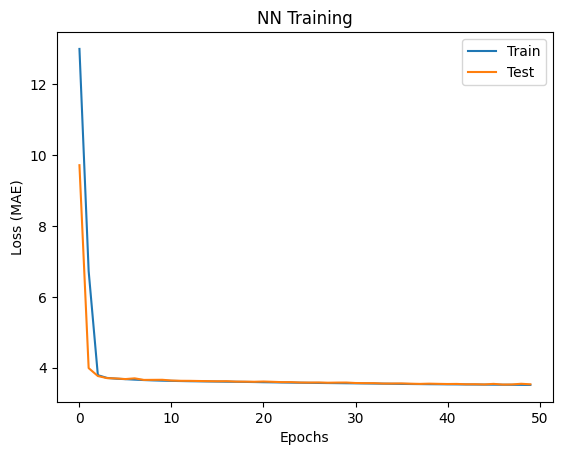

In [ ]:
pl.plot(history.history['loss'],label='Train')
pl.plot(history.history['val_loss'],label='Test')
pl.ylabel('Loss (MAE)')
pl.xlabel('Epochs')
pl.title('NN Training')
pl.legend();

After a few epochs the network has already stopped learning, but the mean average error for the prediction is still high. A bit of experimentation (sorry, not included here...) with the network size and topology showed that *increasing the network complexity doesn't lead to a more accurate prediction*.

# Task V: model evaluation

Here the model predictions for the test set are calculated

In [ ]:
y_test_pred = model.predict(X_test)

72667/72667 [==============================] - 115s 2ms/step


To evaluate the performance of the model, a scatter plot of predicted values versus *true* values was drawn. In case of a totally accurate prediction, we expect the points to fall on a line with unitary slope and passing through the origin.
The scatter plot was drawn using different colors for different coupling types to evaluate correlations between coupling type and good/bad model performance.

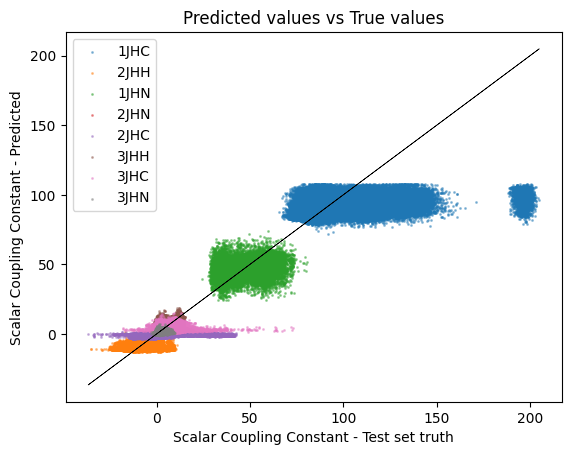

In [ ]:
for t in coupling_types:
  selector = X_test_DF[t]==1
  pl.scatter(y_test[selector],y_test_pred[selector],marker='.',s=5,alpha=0.4,label=t)
pl.plot(y_test,y_test,color="k",linewidth=0.5)
pl.title("Predicted values vs True values")
pl.ylabel("Scalar Coupling Constant - Predicted")
pl.xlabel("Scalar Coupling Constant - Test set truth")
pl.legend()

The overall performance of the model is poor: the predicted value of the coupling constant in good only *on average* for each coupling type. Inside of each coupling type group, the network is unable to give good predictions. This is unlikely explained by lack of data: would be reasonable for values of the coupling constant around 200, but not for the main 1JHC data cluster, which are badly-predicted even if this coupling type is the 3rd more frequent type in the dataset.

Text(0.5, 0, 'Scalar Coupling Constant - Test set truth')

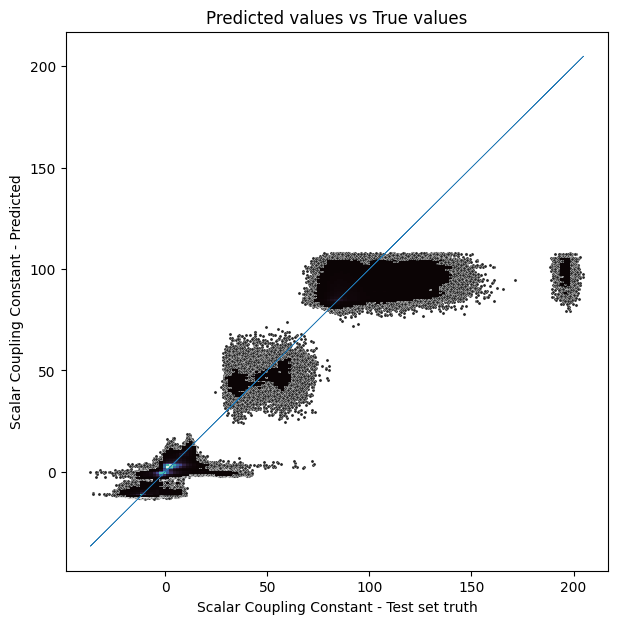

In [ ]:
f, ax = pl.subplots(figsize=(7,7))
sns.scatterplot(x=y_test, y=np.transpose(y_test_pred)[0], s=5, color=".15")
sns.histplot(x=y_test, y=np.transpose(y_test_pred)[0], bins=150, pthresh=.01, cmap="mako")
pl.plot(y_test,y_test,linewidth=0.5)
pl.title("Predicted values vs True values")
pl.ylabel("Scalar Coupling Constant - Predicted")
pl.xlabel("Scalar Coupling Constant - Test set truth")
#sns.kdeplot(x=y_test, y=np.transpose(y_test_pred)[0], levels=5, color="w", linewidths=1)

**To perform better, the model probably needs a dataset containing more features that are meaningful with respect to the physics of this task**

# Task VI: Perform (at least) one additional task

- Alternatively, for whichever model you used
You can **use additional variables or create additional features** by manipulating and combining variables (e.g. the xyz values can be turned into distances like was done for example here https://www.kaggle.com/code/artgor/molecular-properties-eda-and-models/notebook)

To improve the performance, the neural network model was re-created and trained using a different set of features.

*   The merge of coupling data and structure data was carried out as originally, without modifications
*   As suggested, the squared distance between the atoms involved in each atom pair was computed and introduced in the dataset as a new column
*   The number leading the coupling type string was here extracted, converted to numeric and placed on a new column too. Here a numeric encoding was used because the implicit ordering introduced between 1J/2J/3J couplings may be meaningful for the phenomenon we are trying to model.
*   Finally, the remaining part of the coupling type string (HC/HN/HH) was encoded using again the one-hot-encoding approach.





In [ ]:
merged_train = train.merge(structure, left_on=["molecule_name","atom_index_0"], right_on=["molecule_name","atom_index"]);
merged_train = merged_train.merge(structure, left_on=["molecule_name","atom_index_1"], right_on=["molecule_name","atom_index"],suffixes=('_a','_b'));
merged_train.drop(columns=['atom_index_a','atom_a','atom_index_b','atom_b'],inplace=True);
# Extract the first character of the coupling type and convert it to numeric
merged_train["coupling_length"] = merged_train["type"].apply(lambda row: int(row[0]))
# The coupling "length" character is then removed from the coupling type column
merged_train["type"] = merged_train["type"].apply(lambda row: row[2:])
# Compute the squared distance between atoms in each atom paur
merged_train["dist"] = (merged_train["x_a"]-merged_train["x_b"])**2 + (merged_train["y_a"]-merged_train["y_b"])**2 + (merged_train["z_a"]-merged_train["z_b"])**2
coupling_types = merged_train["type"].unique()
# Use one-hot-encoding for the coupling type
merged_train = merged_train.merge(pd.get_dummies(merged_train[u'type']), left_index=True, right_index=True).drop(columns="type")
merged_train

,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,x_a,y_a,z_a,x_b,y_b,z_b,coupling_length,dist,HC,HH,HN
0,dsgdb9nsd_000001,1,0,84.807600,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001,1,1.192361,1,0,0
1,dsgdb9nsd_000001,2,0,84.807400,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001,1,1.192358,1,0,0
2,dsgdb9nsd_000001,3,0,84.809300,-0.540815,1.447527,-0.876644,-0.012698,1.085804,0.008001,1,1.192347,1,0,0
3,dsgdb9nsd_000001,4,0,84.809500,-0.523814,1.437933,0.906397,-0.012698,1.085804,0.008001,1,1.192349,1,0,0
4,dsgdb9nsd_000001,1,2,-11.257000,0.002150,-0.006031,0.001976,1.011731,1.463751,0.000277,2,3.179516,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659071,dsgdb9nsd_133884,13,17,3.062820,2.582409,-1.260138,0.293499,1.126550,-1.348733,-1.933838,3,7.088407,0,1,0
4659072,dsgdb9nsd_133884,16,17,0.789559,-0.084531,1.110807,-1.796741,1.126550,-1.348733,-1.933838,3,7.534847,0,1,0
4659073,dsgdb9nsd_133884,13,14,1.005250,2.582409,-1.260138,0.293499,2.087537,1.391489,0.548687,3,7.341145,0,1,0
4659074,dsgdb9nsd_133884,13,15,1.005260,2.582409,-1.260138,0.293499,1.542918,0.547487,2.023550,3,7.341127,0,1,0


Train and test sets are created from the data set with the same criteria (equal random of molecules, randomly shuffled).

In [ ]:
#sample_size = 2000;
#molecules = merged_train.molecule_name.drop_duplicates().sample(n=2*sample_size,random_state=23)
molecules = merged_train.molecule_name.drop_duplicates().sample(frac=1,random_state=23) # Shuffle molecule names
molecules_train = molecules.sample(frac=0.5,random_state=23)
molecules_test = molecules.drop(molecules_train.index)

Feature distribution was again graphed and checked (it would not be guaranteed if a different random_state was chosen)

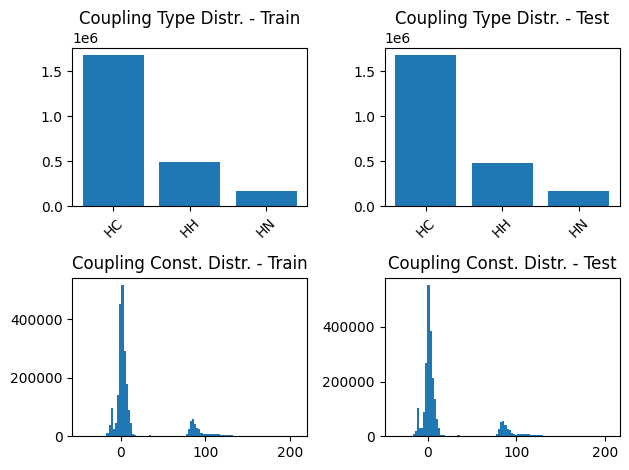

In [ ]:
X_train_DF = pd.DataFrame(molecules_train).merge(merged_train,left_on="molecule_name", right_on="molecule_name")
X_test_DF = pd.DataFrame(molecules_test).merge(merged_train,left_on="molecule_name", right_on="molecule_name")

fig, axes = pl.subplots(nrows=2, ncols=2)
axes[0,0].bar(coupling_types,np.sum(X_train_DF[coupling_types],axis=0))
axes[0,1].bar(coupling_types,np.sum(X_test_DF[coupling_types],axis=0))

y_train = X_train_DF["scalar_coupling_constant"].values
y_test = X_test_DF["scalar_coupling_constant"].values

axes[1,0].hist(y_train,bins=100)
axes[1,1].hist(y_test,bins=100)

X_train = X_train_DF.drop(columns=["molecule_name","atom_index_0","atom_index_1","scalar_coupling_constant"]).values
X_test = X_test_DF.drop(columns=["molecule_name","atom_index_0","atom_index_1","scalar_coupling_constant"]).values

axes[0,0].tick_params(axis='x', labelrotation = 45)
axes[0,1].tick_params(axis='x', labelrotation = 45)
axes[0,0].set_title("Coupling Type Distr. - Train")
axes[0,1].set_title("Coupling Type Distr. - Test")
axes[1,0].set_title("Coupling Const. Distr. - Train")
axes[1,1].set_title("Coupling Const. Distr. - Test")
fig.tight_layout();

The same network topology and number of neurons were used. The dimension of the input was adjusted accordingly to the new number of features.

In [ ]:
ilayer = keras.layers.Dense(16, input_dim=11, activation="tanh")
hlayer1 = keras.layers.Dense(16, activation="tanh")
hlayer2 = keras.layers.Dense(8, activation="tanh")
olayer = keras.layers.Dense(1, activation="linear")
model = keras.Sequential([ilayer, hlayer1, hlayer2, olayer])
model.compile(loss = "mae", optimizer="adam", metrics="mae")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                192       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


The training was performed with the same number of epochs and the same batch size

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(X_test,y_test))

Epoch 1/50
4559/4559 [==============================] - 28s 6ms/step - loss: 13.1592 - mae: 13.1592 - val_loss: 9.9007 - val_mae: 9.9007
Epoch 2/50
4559/4559 [==============================] - 25s 5ms/step - loss: 6.9844 - mae: 6.9844 - val_loss: 4.1490 - val_mae: 4.1490
Epoch 3/50
4559/4559 [==============================] - 28s 6ms/step - loss: 3.6504 - mae: 3.6504 - val_loss: 3.6027 - val_mae: 3.6027
Epoch 4/50
4559/4559 [==============================] - 27s 6ms/step - loss: 3.5606 - mae: 3.5606 - val_loss: 3.5347 - val_mae: 3.5347
Epoch 5/50
4559/4559 [==============================] - 25s 6ms/step - loss: 3.5186 - mae: 3.5186 - val_loss: 3.5337 - val_mae: 3.5337
Epoch 6/50
4559/4559 [==============================] - 27s 6ms/step - loss: 3.4968 - mae: 3.4968 - val_loss: 3.5313 - val_mae: 3.5313
Epoch 7/50
4559/4559 [==============================] - 27s 6ms/step - loss: 3.4802 - mae: 3.4802 - val_loss: 3.4787 - val_mae: 3.4787
Epoch 8/50
4559/4559 [==============================]

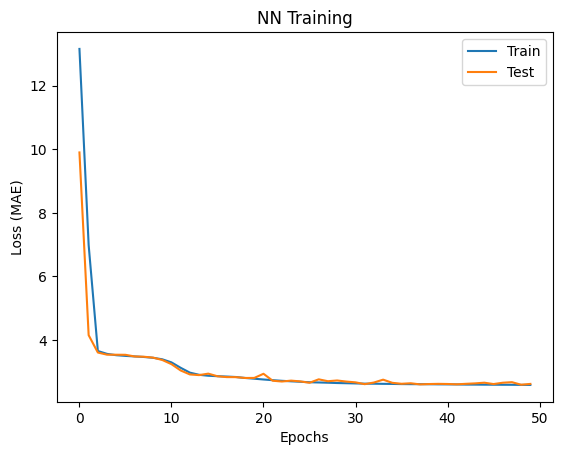

In [ ]:
pl.plot(history.history['loss'],label='Train')
pl.plot(history.history['val_loss'],label='Test')
pl.ylabel('Loss (MAE)')
pl.xlabel('Epochs')
pl.title('NN Training')
pl.legend();

Between 3 and 10 epochs the model learns someting new!

The new predictions were computed:

In [ ]:
y_test_pred = model.predict(X_test)

72667/72667 [==============================] - 119s 2ms/step


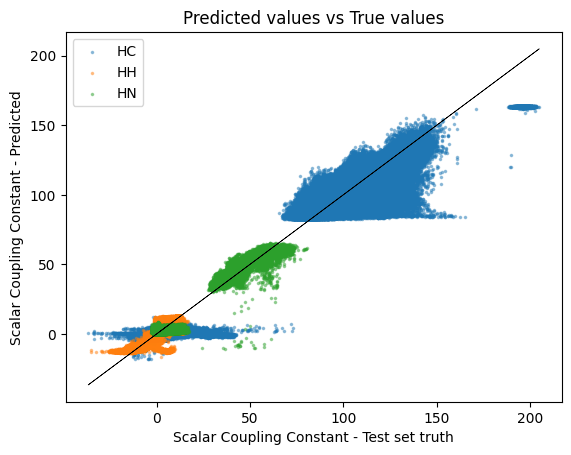

In [ ]:
for t in coupling_types:
  selector = X_test_DF[t]==1
  pl.scatter(y_test[selector],y_test_pred[selector],marker='.',s=10,alpha=0.4,label=t)
pl.plot(y_test,y_test,color="k",linewidth=0.5)
pl.title("Predicted values vs True values")
pl.ylabel("Scalar Coupling Constant - Predicted")
pl.xlabel("Scalar Coupling Constant - Test set truth")
pl.legend()

Here we can see that the model performance has improved. Even if the prediction is still not very accurate, we can observe that inside each cluster now the model gives a prediction that has correlation with the *true* value.

Text(0.5, 0, 'Scalar Coupling Constant - Test set truth')

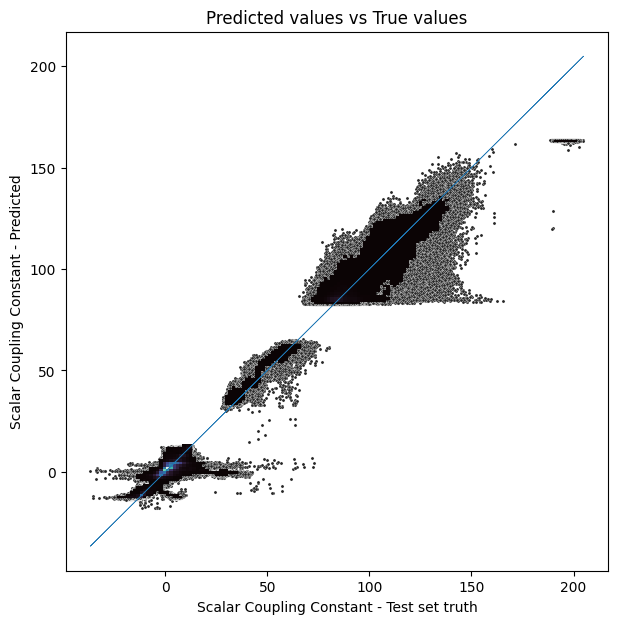

In [ ]:
f, ax = pl.subplots(figsize=(7,7))
sns.scatterplot(x=y_test, y=np.transpose(y_test_pred)[0], s=5, color=".15")
sns.histplot(x=y_test, y=np.transpose(y_test_pred)[0], bins=150, pthresh=.01, cmap="mako")
pl.plot(y_test,y_test,linewidth=0.5)
pl.title("Predicted values vs True values")
pl.ylabel("Scalar Coupling Constant - Predicted")
pl.xlabel("Scalar Coupling Constant - Test set truth")

#Further improvements

Probably a way better approach to the task would be taking into account for each training/prediction **all** the atoms in the structure of the molecule, even the ones present in the structure database but not listed in the coupling constants' database.
...but yet I didn't figure out how to implement this.
